<a href="https://colab.research.google.com/github/Ryukijano/DL_audio/blob/hf_audio_course/hf_audio_data_exploration_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#using hugging-face datasets library
!pip install datasets[audio]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.9 MB/s eta 0:00:00


Loading the dataset MINDS-14 which conatains recordings of people asking an ebanking system questions in several languages and dialects.
To load the MINDS-14 dataset, we need to copy the dataset’s identifier on the Hub (PolyAI/minds14) and pass it to the load_dataset function. We’ll also specify that we’re only interested in the Australian subset (en-AU) of the data, and limit it to the training split:

In [2]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds


Generating train split: 0 examples [00:00, ? examples/s]

Dataset minds14 downloaded and prepared to /root/.cache/huggingface/datasets/PolyAI___minds14/en-AU/1.0.0/65c7e0f3be79e18a6ffaf879a083daf706312d421ac90d25718459cbf3c42696. Subsequent calls will reuse this data.


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

The dataset contains 654 audio files, each of which is accompanied by a transcription, an English translation, and a label indicating the intent behind the person’s query. The audio column contains the raw audio data.

In [3]:
example = minds[0]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

path: the path to the audio file (*.wav in this case).

array: The decoded audio data, represented as a 1-dimensional NumPy array.

sampling_rate. The sampling rate of the audio file (8,000 Hz in this example).

The intent_class is a classification category of the audio recording. To convert this number into a meaningful string, we can use the int2str() method:


In [4]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

The transcription feature shows that the audio file contains a person asking about paying a bill. We can see this by looking at the transcription feature.

If we want to train an audio classifier on this subset of data, we may not need all of the features. For example, the lang_id feature will always have the same value for all examples, so it is not useful. The english_transcription feature is likely to duplicate the transcription, so we can also safely remove it.

We can easily remove irrelevant features using the remove_columns method from the 🤗 Datasets library. This method takes a list of column names as input and removes those columns from the dataset.

In [5]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds


Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

Now that we’ve loaded and inspected the raw contents of the dataset, let’s listen to a few examples! We’ll use the Blocks and Audio features from Gradio to decode a few random samples from the dataset:

In [6]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 

In [7]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:171: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


Using Librosa to plot waveforms

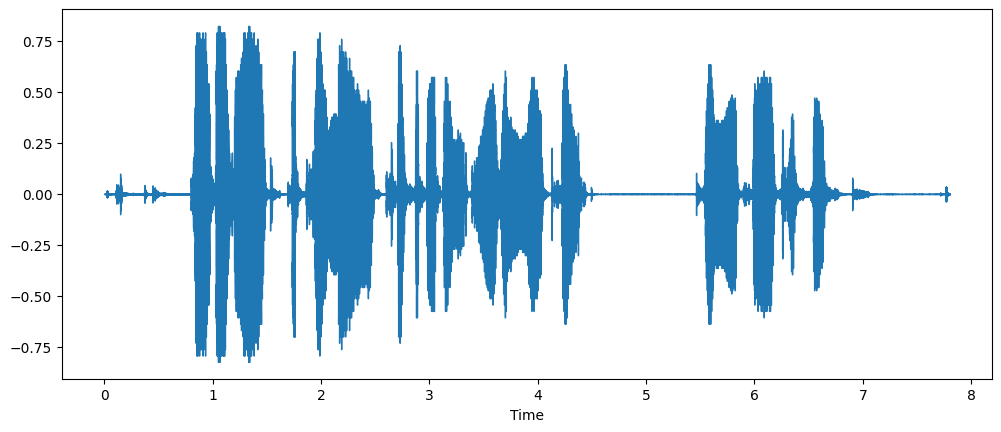

In [8]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

Resampling the audio data

The load_dataset function downloads audio examples with the sampling rate that they were published with. However, the sampling rate expected by a model may be different. If there is a discrepancy between the two, the audio can be resampled to the model's expected sampling rate.

Most of the available pretrained models have been pretrained on audio datasets at a sampling rate of 16 kHz. The MINDS-14 dataset, on the other hand, is sampled at 8 kHz. This means that the audio in the MINDS-14 dataset will need to be upsampled to 16 kHz before it can be used with a pretrained model.

To upsample the audio, the cast_column method from the 🤗 Datasets library can be used. This operation does not change the audio in-place, but rather signals to datasets to resample the audio examples on the fly when they are loaded. The following code will set the sampling rate to 16kHz:



In [9]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [10]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

Filtering the dataset

We may need to filter the data based on some criteria. One of the common cases involves limiting the audio examples to a certain duration. For instance, we might want to filter out any examples longer than 20s to prevent out-of-memory errors when training a model.

We can do this by using the 🤗 Datasets filter method and passing a function with filtering logic to it. Let's start by writing a function that indicates which examples to keep and which to discard. This function, is_audio_length_in_range, returns True if a sample is shorter than 20s, and False if it is longer than 20s.

In [11]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

The filtering function can be applied to a dataset’s column but we do not have a column with audio track duration in this dataset. However, we can create one, filter based on the values in that column, and then remove it.

In [14]:
#using librosa to get example's duration from the audio file
new_column = [librosa.get_duration(filename=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

#use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

#remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

<ipython-input-14-00ca25242e62>:2: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  new_column = [librosa.get_duration(filename=x) for x in minds["path"]]


Flattening the indices:   0%|          | 0/624 [00:00<?, ? examples/s]

Filter:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

Preprocessing the audio data.

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.3 MB/s eta 0:00:00


In [17]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

We are writing a function to pre-prrocess a single audio example by passing it through the feature_extractor

In [18]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

We can apply the data preparation function to all of our training examples using 🤗 Datasets’ map method:

In [20]:
minds = minds.map(prepare_dataset)
minds


Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

Visualizing an example

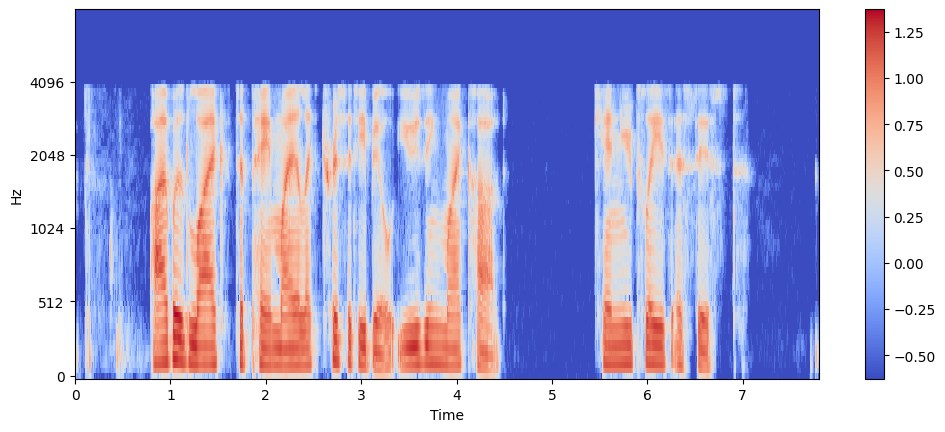

In [21]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

Using AutoProcessor to load a model's feature extractor and processor from a checkpoint


In [22]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

Streaming datasets

In [24]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [26]:
gigaspeech = load_dataset("speechcolab/gigaspeech", "xs", streaming=True)

Preprocessing gigaspeech

Accessing an example when streaming a dataset.

In [28]:
next(iter(gigaspeech["train"]))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}

In [30]:
#previewing more examples
gigaspeech_head = gigaspeech["train"].take(2)
list(gigaspeech_head)

[{'segment_id': 'YOU0000000315_S0000660',
  'speaker': 'N/A',
  'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
  'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
   'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
          0.00036621]),
   'sampling_rate': 16000},
  'begin_time': 2941.89,
  'end_time': 2945.07,
  'audio_id': 'YOU0000000315',
  'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
  'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
  'source': 2,
  'category': 24,
  'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'},
 {'segment_id': 'AUD0000001043_S0000775',
  'speaker': 'N/A',
  'text': 'SIX TOMATOES <PERIOD>',
  'audio': {'path': 'xs_chunks_0000/AUD0000001043_S0000775.wav',
   'array': array([ 1.43432617e-03,  1.37329102e-03,  1.31225586e-03, ...,
          -6.10351562e-05, -1.22070312e-04, -1.83105469e-04]),
   'sampling_rate': 16000},
 